## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import ll_to_xy
import matplotlib.patheffects as pe
from netCDF4 import Dataset

import warnings
warnings.filterwarnings('ignore')

## 1. Simulation Data

In [3]:
variable = 'PRCP'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

### 1.1 ERA5

#### 1.1.1 Data Options

In [4]:
run_data = 'era5'

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [5]:
data_path

['data/era5_LIN_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_LIN_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_urban_PRCP_wrfout_d03_2017-07-18.nc']

#### 1.1.2 Open Data

In [6]:
# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt_era5 = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

# sum over time dimension
dt_era5_sum = dt_era5.sum(dim='time')

In [7]:
dt_era5_sum

<xarray.DataArray 'PRCP' (ens: 6, south_north: 200, west_east: 200)>
dask.array<sum-aggregate, shape=(6, 200, 200), dtype=float32, chunksize=(1, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * ens          (ens) object 'LIN_nourban_PRCP' ... 'WSM6_urban_PRCP'
    spatial_ref  int64 0

#### 1.1.3 Define Members

In [8]:
# ensemble member list
ensemble_members = list(dt.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

#### 1.1.4 Ensemble Mean For Urban and Nourban

In [9]:
dt_era5_sum_urban_ens = dt_era5_sum.sel(ens=urban_members).mean(dim='ens')
dt_era5_urban_ens = dt_era5.sel(ens=urban_members).mean(dim='ens')

In [10]:
dt_era5_sum_urban_ens

<xarray.DataArray 'PRCP' (south_north: 200, west_east: 200)>
dask.array<mean_agg-aggregate, shape=(200, 200), dtype=float32, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
    spatial_ref  int64 0

### 1.2 GFS

#### 1.2.1 Data Options

In [11]:
run_data = 'gfs' # gfs in normal

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [12]:
data_path

['data/gfs_LIN_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_LIN_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_THOMPSON_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_THOMPSON_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_WSM6_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_WSM6_urban_PRCP_wrfout_d03_2017-07-18.nc']

#### 1.1.2 Open Data

In [13]:
# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens')[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt_gfs = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

# sum over time dimension
dt_gfs_sum = dt_gfs.sum(dim='time')

In [14]:
dt_gfs_sum

<xarray.DataArray 'PRCP' (ens: 6, south_north: 200, west_east: 200)>
dask.array<sum-aggregate, shape=(6, 200, 200), dtype=float32, chunksize=(1, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * ens          (ens) object 'LIN_nourban_PRCP' ... 'WSM6_urban_PRCP'
    spatial_ref  int64 0

#### 1.1.3 Ensemble Mean For Urban and Nourban

In [15]:
dt_gfs_sum_urban_ens = dt_gfs_sum.sel(ens=urban_members).mean(dim='ens')
dt_gfs_urban_ens = dt_gfs.sel(ens=urban_members).mean(dim='ens')

In [16]:
dt_gfs_sum_urban_ens

<xarray.DataArray 'PRCP' (south_north: 200, west_east: 200)>
dask.array<mean_agg-aggregate, shape=(200, 200), dtype=float32, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
    spatial_ref  int64 0

## 2. Observation (MGM) Data

In [17]:
def adjust_station_data(dt, start_year, end_year):
    
    # dates queried: 2011 to 2018
    date_query = list(range(start_year, end_year+1))
    dt = dt.query(f'Year in {date_query}').reset_index(drop=True)

    # change -999 to np.nan
    dt = dt.where(dt!=-999, np.nan)
    
    # int to str
    dt[['Year', 'Month', 'Day', 'Hour']] = dt[['Year', 'Month', 'Day', 'Hour']].astype(str)

    # add new datetime col
    dt['Date'] = pd.to_datetime(dt[['Year', 'Month', 'Day', 'Hour']])
    
    return dt

def retrieve_station(province):
    """
    Adjusts and retrieves station dataset
        of corresponding province.
    """
    
    data_source = 'mgm'
    var_name = 'P' # possible: T, P
    unit = 'mm'

    # define general path to datasets
    general_path = f'data/observation/{data_source}/{var_name}.xlsx'

    # get individual data links
    data_links = glob(general_path)

    # open dataframe
    dt = pd.read_excel(data_links[0])
    
    # set attributes
    dt.attrs['data-source'] = data_source
    dt.attrs['var-name'] = var_name
    dt.attrs['unit'] = unit
    dt.attrs['province'] = province
    
    return dt

def get_station_metadata(province):
    
    data_source = 'mgm'
    dt = pd.read_excel(fr'data/observation/{data_source}/locations.xlsx')
    dt.attrs['data-source'] = 'station metadata'
    dt.attrs['province'] = province
    dt.attrs['height-unit'] = 'm'
    
    return dt

In [18]:
province = 'istanbul'
observation = adjust_station_data(retrieve_station(province), 2017, 2018)
observation = observation.query('Year=="2017" and Month=="7" and Day=="18"').reset_index(drop=True).drop(columns = ['Year', 'Month', 'Day', 'Hour'])
observation_sum = observation.sum(axis=0).to_frame().T

In [19]:
observation_sum.columns

Index([17047, 17059, 17061, 17062, 17064, 17065, 17388, 17389, 17437, 17438,
       17448, 17454, 17455, 17603, 17610, 17636, 17813, 17814, 18099, 18100,
       18101, 18396, 18397, 18399, 18400, 18401, 18402, 18403, 18404, 18421,
       18734, 18735, 18736, 18792, 18793, 18980, 19110, 19111, 19112, 19365,
       20017],
      dtype='object')

In [20]:
metadata = get_station_metadata(province)
metadata = metadata[metadata['station'].isin(observation_sum.columns)].reset_index(drop=True)
metadata

,station,y,x
0,17047,41.340900,28.356800
1,17059,41.250500,29.038400
2,17061,41.146400,29.050200
3,17062,40.988300,29.019000
4,17064,40.911300,29.155800
5,17065,40.986600,29.213500
6,17603,41.015500,28.960100
7,17610,41.168800,29.600700
8,17636,40.975800,28.786500
9,17388,41.043333,28.182222


### 2.1 Merge Observation Daily Sum  and Metadata

In [21]:
observation_drop_0 = observation_sum.T[observation_sum.T[0]!=0.0]

In [22]:
observation_drop_0 = observation_drop_0.reset_index().rename(columns={'index':'station'})

In [23]:
metadata_observation_merged = pd.merge(observation_drop_0, metadata)

In [24]:
metadata_observation_merged

,station,0,y,x
0,17047,56.0,41.340900,28.356800
1,17059,44.4,41.250500,29.038400
2,17061,73.6,41.146400,29.050200
3,17062,16.8,40.988300,29.019000
4,17064,25.7,40.911300,29.155800
5,17065,21.8,40.986600,29.213500
6,17454,1.6,41.004200,28.954700
7,17603,31.2,41.015500,28.960100
8,17610,43.7,41.168800,29.600700
9,17636,6.0,40.975800,28.786500


## 3. IMERG Data

In [25]:
# define general path to datasets
data_source = 'imerg'
imerg_var = 'IRprecipitation'
general_path = f'data/observation/{data_source}/*20170718*'

# get individual data links
data_links = glob(general_path)
imerg = xr.open_mfdataset(data_links)

# adjust imerg units and turn it from 30 mins interval to 1 hour sums
imerg = imerg.resample(time = '1H').sum()[imerg_var]
imerg = imerg.transpose(transpose_coords = ['lat', 'lon'])
imerg_sum = imerg.sum(dim='time')

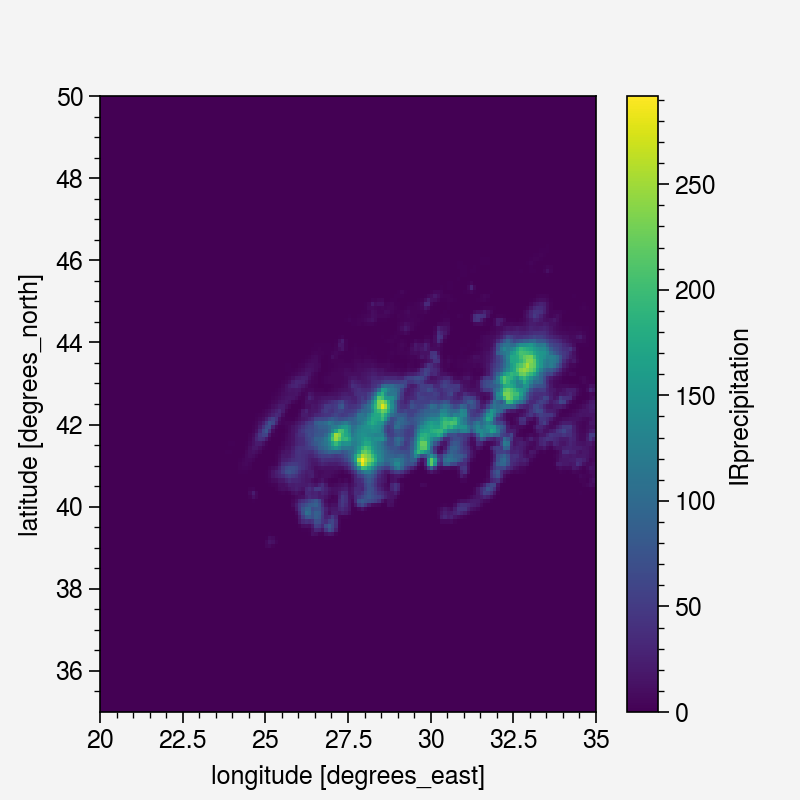

In [26]:
imerg_sum.plot()

## 4. Point Data From Spatial Data

In [27]:
def assign_date_info(from_, to_):
    to_['Date'] = from_['Date']
    
    return to_

### 4.1 WRF Data

In [28]:
xy_index_data = Dataset(r'../../../Desktop/istanbul/geo_em.d03.nc')

In [29]:
xy_locations = np.zeros((41, 2), dtype=int)

for i in range(len(metadata)):
    x,y = ll_to_xy(xy_index_data, metadata.iloc[i, 1], metadata.iloc[i, 2])
    xy_locations[i, 0] = y
    xy_locations[i, 1] = x

In [30]:
xy_locations

array([[139,  58],
       [129, 114],
       [117, 115],
       [100, 113],
       [ 91, 124],
       [100, 129],
       [103, 108],
       [120, 162],
       [ 98,  93],
       [106,  43],
       [ 94, 107],
       [ 85, 134],
       [109,  48],
       [ 80, 136],
       [101, 107],
       [127, 121],
       [ 99, 116],
       [104, 102],
       [106,  77],
       [ 82, 136],
       [112, 105],
       [117, 117],
       [110, 139],
       [102, 135],
       [122,  41],
       [107, 109],
       [126,  87],
       [104, 123],
       [105, 115],
       [126, 125],
       [138,  79],
       [113, 181],
       [102, 140],
       [106, 159],
       [135,  43],
       [112, 113],
       [ 97,  80],
       [120,  69],
       [ 93, 130],
       [124, 120],
       [106,  63]])

In [31]:
dt_era5_wrf_point = {}
dt_gfs_wrf_point = {}

for i in range(len(metadata)):
    
    dt_e = dt_era5_urban_ens.isel(south_north=xy_locations[i, 0], west_east=xy_locations[i, 1])
    dt_g = dt_gfs_urban_ens.isel(south_north=xy_locations[i, 0], west_east=xy_locations[i, 1])
    
    dt_era5_wrf_point[metadata.iloc[i, 0]] = list(dt_e.values)
    dt_gfs_wrf_point[metadata.iloc[i, 0]] = list(dt_g.values)    

In [32]:
wrf_era5_pd = pd.DataFrame(dt_era5_wrf_point)
wrf_era5_pd = assign_date_info(observation, wrf_era5_pd)

In [33]:
wrf_gfs_pd = pd.DataFrame(dt_gfs_wrf_point)
wrf_gfs_pd = assign_date_info(observation, wrf_gfs_pd)

### 4.2 IMERG data

In [34]:
dt_imerg_point = {}

for i in range(len(metadata)):
    
    dt_ = imerg.sel(lat=metadata.iloc[i, 1], lon=metadata.iloc[i, 2], method='nearest')
    dt_imerg_point[metadata.iloc[i, 0]] = list(dt_.values)

In [35]:
imerg_pd = pd.DataFrame(dt_imerg_point)
imerg_pd = assign_date_info(observation, imerg_pd)

## 5. Plot

### 5.1 Options

In [36]:
observation = observation.set_index('Date')
wrf_era5_pd = wrf_era5_pd.set_index('Date')
wrf_gfs_pd = wrf_gfs_pd.set_index('Date')
imerg_pd = imerg_pd.set_index('Date')

In [37]:
observation_mean = observation.cumsum(axis=0).mean(axis = 1)
wrf_era5_pd_mean = wrf_era5_pd.cumsum(axis=0).mean(axis = 1)
wrf_gfs_pd_mean = wrf_gfs_pd.cumsum(axis=0).mean(axis = 1)
imerg_pd_mean = imerg_pd.cumsum(axis=0).mean(axis = 1)

In [38]:
luse_var = 'LU_INDEX'
urban_luse_border = xr.open_dataset(fr'data/wrfout_d03_LU_INDEX_urban.nc')[luse_var]
urban_luse_border = urban_luse_border.where(urban_luse_border==1, 0).isel(west_east = slice(35, 162),
                                                                               south_north = slice(57, 157))

In [39]:
# cmap for total urban and nourban hourly precipitation
nws_precip_colors_total = [
    "#FFFFFF",
    "#a9dff9",
    "#8acef5",
    "#67aae1", 
    "#4aa77a", 
    "#a2cf5a", 
    "#fed755", 
    "#f29a3e", 
    "#ef6934",
    "#cf212a",
    "#620878",
    "#c611f2",
    "#db7cf2"
    
]
cmap = ListedColormap(nws_precip_colors_total)

In [40]:
# add shapefiles
turkey_district_shape = r'data/shapefiles/istanbul_province_borders.shp'
turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'

In [41]:
# Parameters to change (plot) -------------------
# projection
proj = dt.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1, 2, 3, 4],
             [5,6,7,8]
            ]
graphic_no = 8

clevs_total = [0, 12, 24, 36, 60, 84, 120, 156, 200, 250, 300, 350, 500, 650]
norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)
ticks = clevs_total

### 5.2 Graphic

In [42]:
proplot.rc['toplabel.size'] = 13
proplot.rc['ticklabelsize'] = 12

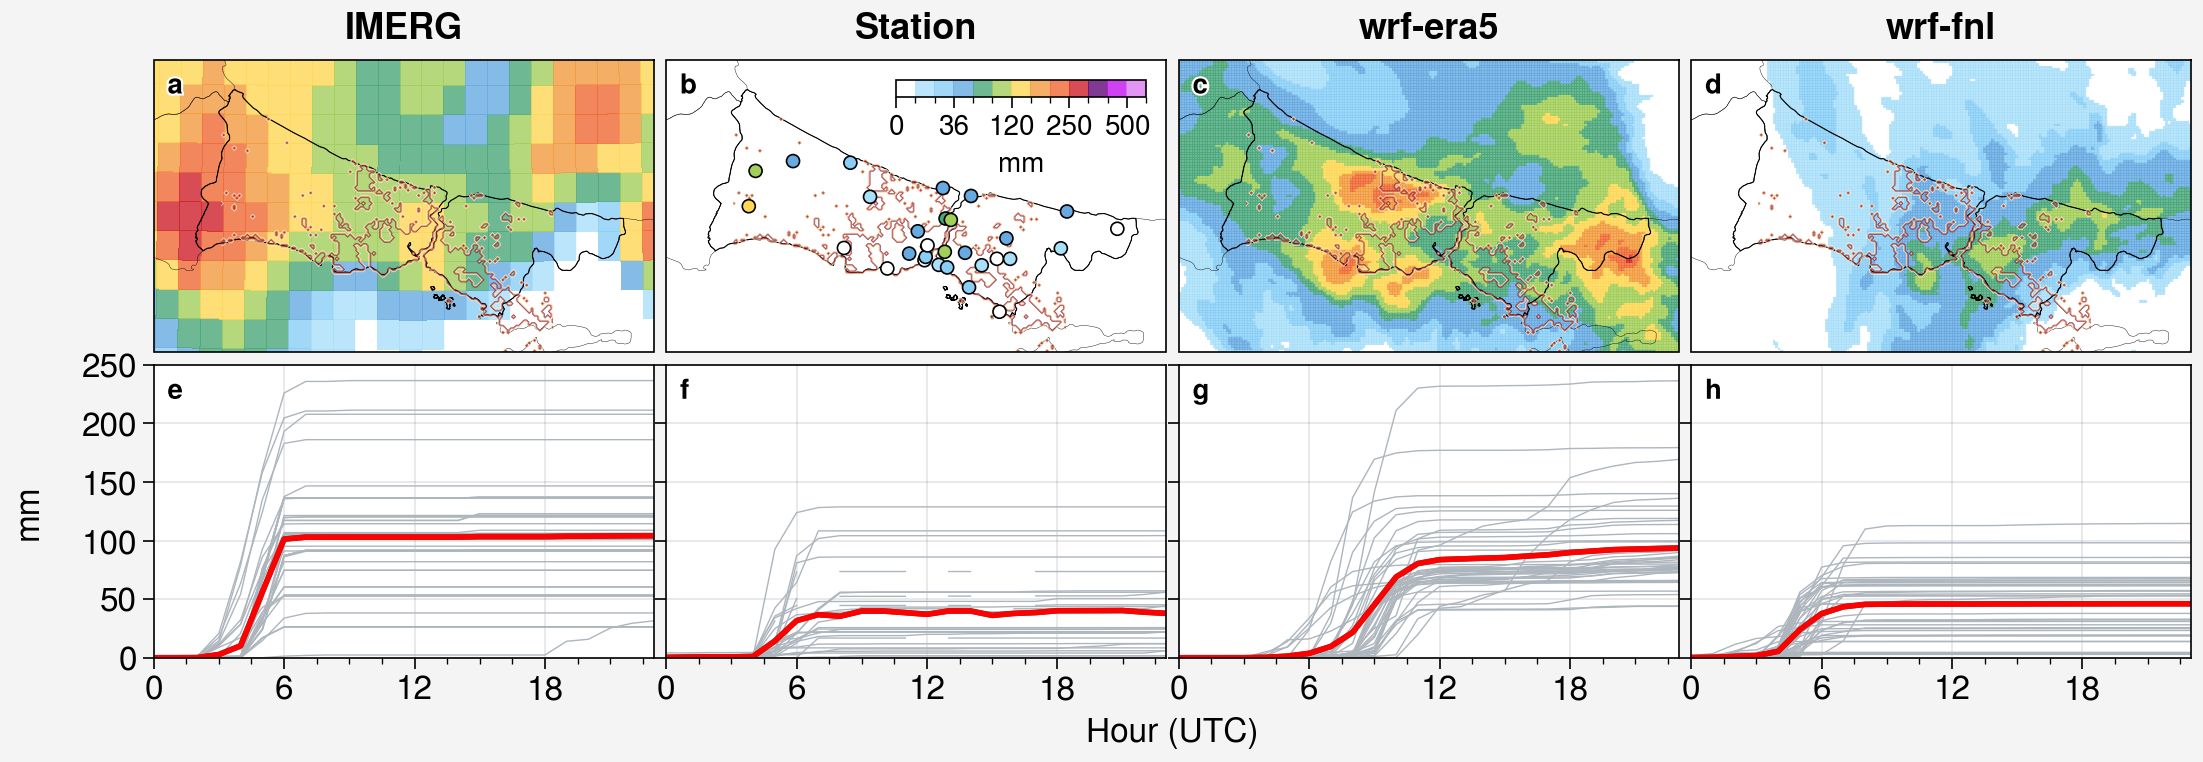

In [43]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            #aspect=4,
                            #axwidth=2,
                            proj=[lcc, lcc, lcc, lcc, None, None, None, None],
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.50,
                            wspace=0.5,
                            #share = 0,
                            sharex=4,
                            sharey = 4
                           )

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# istanbul limits
axs[:4].format(lonlim=(27.69171143+0.10, 30.04271274),
           latlim=(40.08444595+0.60, 41.88309609-0.20),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(collabels=['IMERG', 'Station', 'wrf-era5', 'wrf-fnl'],
           #collabelsize=12,
           labelsize=12
           #collabels=['08UTC', '09UTC', '10UTC', '11UTC']
           )

# add shapefiles
shape_district_turkey = ShapelyFeature(Reader(turkey_district_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.4, zorder = 0.3)

shape_province_turkey = ShapelyFeature(Reader(turkey_province_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.15, zorder = 0.4)

for i in range(int(graphic_no/2)):
    axs[i].add_feature(shape_district_turkey)
    axs[i].add_feature(shape_province_turkey)  
    
# spatial graphics
dt_border = urban_luse_border
for t in range(int(graphic_no/2)):
        
    if t == 2:
        mesh = axs[t].pcolormesh(dt_era5_sum_urban_ens['lon'], 
                            dt_era5_sum_urban_ens['lat'],
                            dt_era5_sum_urban_ens, 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8,
                            #extend = 'max'
                                )
    elif t == 3:
        mesh = axs[t].pcolormesh(dt_gfs_sum_urban_ens['lon'], 
                            dt_gfs_sum_urban_ens['lat'],
                            dt_gfs_sum_urban_ens, 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8,
                            #extend = 'max'
                                )
        
    elif t == 0:
        mesh = axs[t].pcolormesh(imerg_sum['lon'], 
                            imerg_sum['lat'],
                            imerg_sum, 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8,
                            #extend = 'max'
                                )
        
    elif t == 1:
        mesh = axs[t].scatter( metadata_observation_merged['x'].values,
                       metadata_observation_merged['y'].values,
                       c = metadata_observation_merged.iloc[:, 1].values,
                       marker = "o",
                       markersize = 22,
                       markeredgecolor = 'k',
                       cmap = cmap,
                       norm = norm,
                       #transform=cartopy.crs.PlateCarree(),
                       zorder = 10.2)
        
    contour = axs[t].contour(dt_border['lon'], 
                            dt_border['lat'],
                            dt_border,
                            linewidth = 0.1
                            )
    
# temporal graphics
# path effect feature
path_effect = [pe.Stroke(linewidth=2, foreground='#403f3f'),
                    pe.Normal()]

# original data
dts = [imerg_pd.cumsum(axis=0), observation.cumsum(axis=0),
       wrf_era5_pd.cumsum(axis=0), wrf_gfs_pd.cumsum(axis=0)]
# means
dts_mean = [imerg_pd_mean, observation_mean,
            wrf_era5_pd_mean, wrf_gfs_pd_mean]

vmin,vmax = 0, 250
for i in range(4, int(graphic_no)):
    lp = axs[i].plot(dts[i-4].reset_index(drop=True).values,
                     colors='gray5', lw=0.5,
 
                     )  
    
    lp_mean = axs[i].plot(dts_mean[i-4].reset_index(drop=True).values,
                          colors='red', lw=2,
                          path_effects=path_effect,
                    )
    #axs[i].format(xformatter='%H')
    axs[i].set_ylim([vmin, vmax])
    axs[i].set_xlabel('Hour (UTC)')  
    axs[i].set_ylabel('mm')   
    axs[i].set_yticks([0, 50, 100, 150, 200, 250])
    axs[i].set_xticks([0, 6, 12, 18])    
    
axs[5:].format(ytickminor=False, ylabel='')

# colorbars
axs[1].colorbar(mesh,
                 label='mm',
                 ticks = ticks,
                 loc='ur', length=10,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.7,
                 labelsize = 10,
                 ticklabelsize = 10,
                 frame=False,
                 pad = 0.8
                )

#save figure
plt.savefig(r'pictures/combined_verification.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)